# Load Data

In [1]:
! pip install pytorch_pretrained_bert
! pip install torchmetrics
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Capstone')
from utils import read_conll_file, read_data, filter_tag, create_sub_dir
from utils import (TAG2IDX, IDX2TAG, DATA_DIR, WSJ_DIR, MODEL_DIR, 
                   INT_RESULT_DIR, METRICS_DIR, RESULT_DIR, PLOT_TAGS_DIR)
from utils import wsj_train_word_lst, wsj_train_tag_lst, wsj_test_word_lst, wsj_test_tag_lst

from build_model import PosDataset, Net, DEVICE, TOKENIZER
from build_model import pad, train, eval

from analysis import save_sns_fig, save_plotly_fig, analysis_output

from create_pseudo_data_by_tokens import gen_pseudo_data_for_token

import os
from collections import Counter
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer, BertModel
from torchmetrics.functional.classification import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy

torch.manual_seed(0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The number of samples: 30060
The number of tags 48
The number of samples: 1336
The number of tags 45
The number of samples: 1640
The number of tags 45


In [3]:
model = Net(vocab_size=len(TAG2IDX))
model.to(DEVICE)
model = nn.DataParallel(model)

In [4]:
train_dataset = PosDataset(wsj_train_word_lst, wsj_train_tag_lst)
eval_dataset = PosDataset(wsj_test_word_lst, wsj_test_tag_lst)

train_iter = data.DataLoader(dataset=train_dataset,
                             batch_size=8,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
test_iter = data.DataLoader(dataset=eval_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [5]:
model_file = os.path.join(MODEL_DIR, "base_model.pt")
model.load_state_dict(torch.load(model_file))
(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value, 
 micro_wsj_precision_value, micro_wsj_recall_value, micro_wsj_f1_value, micro_wsj_acc_value,
 macro_wsj_precision_value, macro_wsj_recall_value, macro_wsj_f1_value, macro_wsj_acc_value) = eval(model, test_iter, save_output=False)

print(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value)
print(micro_wsj_precision_value, micro_wsj_recall_value, micro_wsj_f1_value, micro_wsj_acc_value)
print(macro_wsj_precision_value, macro_wsj_recall_value, macro_wsj_f1_value, macro_wsj_acc_value)


tensor(0.9771) tensor(0.9743) tensor(0.9751) tensor(0.9743)
tensor(0.9743) tensor(0.9743) tensor(0.9743) tensor(0.9743)
tensor(0.8648) tensor(0.8656) tensor(0.8558) tensor(0.8656)


# Self Training

In [6]:
file_name_lst = ["answers", "emails", "newsgroups", "reviews", "weblogs"]

In [7]:
domain = "emails"
domain_dir = os.path.join(DATA_DIR, "pos_fine", f"{domain}")
domain_dev_file = os.path.join(domain_dir, f"gweb-{domain}-dev.conll")
domain_test_file = os.path.join(domain_dir, f"gweb-{domain}-test.conll")

In [8]:
domain_dev_word_lst, domain_dev_tag_lst, domain_dev_tag_set = read_data(domain_dev_file)
domain_test_word_lst, domain_test_tag_lst, domain_test_tag_set = read_data(domain_test_file)
domain_dev_word_lst, domain_dev_tag_lst = filter_tag(domain_dev_word_lst, domain_dev_tag_lst)  
domain_test_word_lst, domain_test_tag_lst = filter_tag(domain_test_word_lst, domain_test_tag_lst)

The number of samples: 2450
The number of tags 49
The number of samples: 2450
The number of tags 48
after filter tag 2427
after filter tag 2402


In [9]:
# method_name: Online_fixed_self_learning, Online_nonfixed_self_learning, 
#               Scratch_fixed_self_learning, Scratch_nonfixed_self_learning,
#               Online_token_self_learning, Scratch_token_self_learning

(sub_model_dir, sub_metrics_dir, sub_result_dir, 
 sub_plots_tags_dir, sub_int_res_dir) = create_sub_dir(domain, method_name="Online_token_self_learning")

In [10]:
domain_precision_value_lst = []
domain_recall_value_lst = []
domain_f1_value_lst = []
domain_acc_value_lst = []

micro_domain_precision_value_lst = []
micro_domain_recall_value_lst = []
micro_domain_f1_value_lst = []
micro_domain_acc_value_lst = []

macro_domain_precision_value_lst = []
macro_domain_recall_value_lst = []
macro_domain_f1_value_lst = []
macro_domain_acc_value_lst = []

In [11]:
loop_i = 0
token_top_percent = 0.2
cnt_non_ignored_tokens = sum([len(s) for s in domain_dev_word_lst])
token_topn = int(token_top_percent * cnt_non_ignored_tokens)
print("The number of non_ignored_tokens", cnt_non_ignored_tokens)
print("The number of token_topn", token_topn)

The number of non_ignored_tokens 28898
The number of token_topn 5779


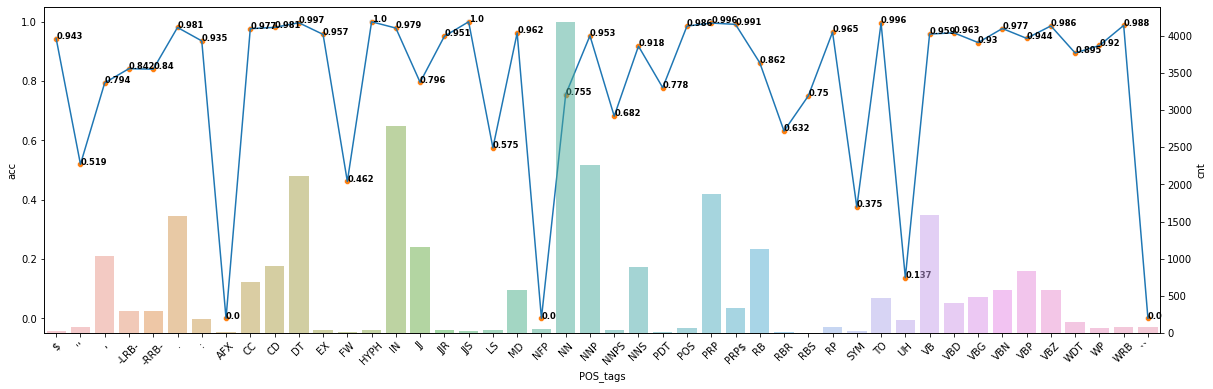

In [12]:
domain_test_dataset = PosDataset(domain_test_word_lst, domain_test_tag_lst)

domain_test_iter = data.DataLoader(dataset=domain_test_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

output_res_file = os.path.join(sub_result_dir, f"top{token_top_percent}-loop{loop_i}.txt")
(domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value,
 precision_value_micro, recall_value_micro, f1_value_micro, acc_micro, 
 precision_value_macro, recall_value_macro, f1_value_macro, acc_macro) = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

csv_file_name = os.path.join(sub_plots_tags_dir, f"top{token_top_percent}-loop{loop_i}.csv")
output_plot_name = os.path.join(sub_plots_tags_dir, f"top{token_top_percent}-loop{loop_i}.png")
_ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)

domain_precision_value_lst.append(domain_precision_value)
domain_recall_value_lst.append(domain_recall_value)
domain_f1_value_lst.append(domain_f1_value)
domain_acc_value_lst.append(domain_acc_value)

micro_domain_precision_value_lst.append(precision_value_micro)
micro_domain_recall_value_lst.append(recall_value_micro)
micro_domain_f1_value_lst.append(f1_value_micro)
micro_domain_acc_value_lst.append(acc_micro)

macro_domain_precision_value_lst.append(precision_value_macro)
macro_domain_recall_value_lst.append(recall_value_macro)
macro_domain_f1_value_lst.append(f1_value_macro)
macro_domain_acc_value_lst.append(acc_macro)



Loop 1
domain_dev_word_lst 2427


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data_by_tokens.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


2427
Total non_ignored tokens 28898
threshold_prob: 0.9998353719711304
Online Training ...
step: 0, loss: 0.00019416549184825271
step: 10, loss: 9.39196179388091e-05
step: 20, loss: 7.405370706692338e-05
step: 30, loss: 6.340914842439815e-05
step: 40, loss: 3.255121919210069e-05
step: 50, loss: 4.7754874685779214e-05
step: 60, loss: 4.097947748959996e-05
step: 70, loss: 4.4384483771864325e-05
step: 80, loss: 4.2970263166353106e-05
step: 90, loss: 4.401685146149248e-05
step: 100, loss: 4.2602601752150804e-05
step: 110, loss: 4.818427987629548e-05
step: 120, loss: 4.427021849551238e-05
step: 130, loss: 5.527838948182762e-05
step: 140, loss: 4.3748765165219083e-05
step: 150, loss: 4.653372161556035e-05
step: 160, loss: 4.6438301069429144e-05
step: 170, loss: 5.018893352826126e-05
step: 180, loss: 3.9253001887118444e-05
step: 190, loss: 4.266099494998343e-05
step: 200, loss: 3.8319001760100946e-05
step: 210, loss: 4.633696880773641e-05
step: 220, loss: 5.175310070626438e-05
step: 230, loss

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data_by_tokens.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


2427
Total non_ignored tokens 23116
threshold_prob: 0.9995347261428833
Online Training ...
step: 0, loss: 0.00016370329831261188
step: 10, loss: 0.00046630363794974983
step: 20, loss: 0.00018403734429739416
step: 30, loss: 9.071367821888998e-05
step: 40, loss: 0.0001320159644819796
step: 50, loss: 0.0001464093802496791
step: 60, loss: 7.845556683605537e-05
step: 70, loss: 0.000107113468402531
step: 80, loss: 0.00012550860992632806
step: 90, loss: 0.00013149288133718073
step: 100, loss: 9.636810136726126e-05
step: 110, loss: 7.714100502198562e-05
step: 120, loss: 7.427873788401484e-05
step: 130, loss: 7.437731983372942e-05
step: 140, loss: 8.508711471222341e-05
step: 150, loss: 4.238340989104472e-05
step: 160, loss: 8.929303294280544e-05
step: 170, loss: 9.592524293111637e-05
step: 180, loss: 8.305570372613147e-05
step: 190, loss: 8.335957681993023e-05
step: 200, loss: 0.00015522967441938818
step: 210, loss: 8.12093639979139e-05
step: 220, loss: 7.143963011913002e-05
step: 230, loss: 9.

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data_by_tokens.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


2427
Total non_ignored tokens 17341
threshold_prob: 0.9992857575416565
Online Training ...
step: 0, loss: 0.00028023900813423097
step: 10, loss: 0.00016198368393816054
step: 20, loss: 0.00019850344688165933
step: 30, loss: 0.00011900004028575495
step: 40, loss: 8.3381004515104e-05
step: 50, loss: 0.0001470553397666663
step: 60, loss: 0.0002057512174360454
step: 70, loss: 0.00014139525592327118
step: 80, loss: 0.00011060273391194642
step: 90, loss: 6.555199070135131e-05
step: 100, loss: 0.00011259142047492787
step: 110, loss: 0.00010038812615675852
step: 120, loss: 0.00010689638293115422
step: 130, loss: 0.0001049499842338264
step: 140, loss: 9.004887397168204e-05
step: 150, loss: 7.968648424139246e-05
step: 160, loss: 0.00044797814916819334
step: 170, loss: 0.00012103810149710625
step: 180, loss: 6.386607128661126e-05
step: 190, loss: 0.1938311606645584
step: 200, loss: 8.372405864065513e-05
step: 210, loss: 6.885808397782966e-05
step: 220, loss: 0.00010408324305899441
step: 230, loss:

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data_by_tokens.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


2427
Total non_ignored tokens 11561
threshold_prob: 0.9927252531051636
Online Training ...
step: 0, loss: 0.0010271428618580103
step: 10, loss: 0.0008482825360260904
step: 20, loss: 0.0008631541859358549
step: 30, loss: 0.0003628294507507235
step: 40, loss: 0.0007891611894592643
step: 50, loss: 0.001909678685478866
step: 60, loss: 0.0006267623975872993
step: 70, loss: 0.00026067483122460544
step: 80, loss: 0.0002888029848691076
step: 90, loss: 0.00025851631653495133
step: 100, loss: 0.0004201538977213204
step: 110, loss: 0.0009486289927735925
step: 120, loss: 0.0003369791666045785
step: 130, loss: 0.0003636814944911748
step: 140, loss: 0.02963123470544815
step: 150, loss: 0.0008561152499169111
step: 160, loss: 0.0003817204851657152
step: 170, loss: 0.0003712851903401315
step: 180, loss: 0.0003819277626462281
step: 190, loss: 0.0003590350388549268
step: 200, loss: 0.00032904662657529116
step: 210, loss: 0.0002672971459105611
step: 220, loss: 0.00024612926063127816
step: 230, loss: 0.000

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data_by_tokens.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


2427
Total non_ignored tokens 5782
threshold_prob: 0.1386987864971161
Online Training ...
step: 0, loss: 0.05168182775378227
step: 10, loss: 0.06514157354831696
step: 20, loss: 0.07387366890907288
step: 30, loss: 0.03293129429221153
step: 40, loss: 0.07450874149799347
step: 50, loss: 0.12257498502731323
step: 60, loss: 0.028204506263136864
step: 70, loss: 0.04892035946249962
step: 80, loss: 0.06778731942176819
step: 90, loss: 0.00464238366112113
step: 100, loss: 0.019384050741791725
step: 110, loss: 0.043559037148952484
step: 120, loss: 0.03166235238313675
step: 130, loss: 0.007145354058593512
step: 140, loss: 0.054491713643074036
step: 150, loss: 0.05823904275894165
step: 160, loss: 0.04344293475151062
step: 170, loss: 0.03947761654853821
step: 180, loss: 0.08145090937614441
step: 190, loss: 0.13929511606693268
step: 200, loss: 0.11409087479114532
step: 210, loss: 0.024263573810458183
step: 220, loss: 0.009054737165570259
step: 230, loss: 0.12368994206190109
step: 240, loss: 0.0259889

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data_by_tokens.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


2427
Total non_ignored tokens 2
The number of non-ignored tokens is too few. Stop training


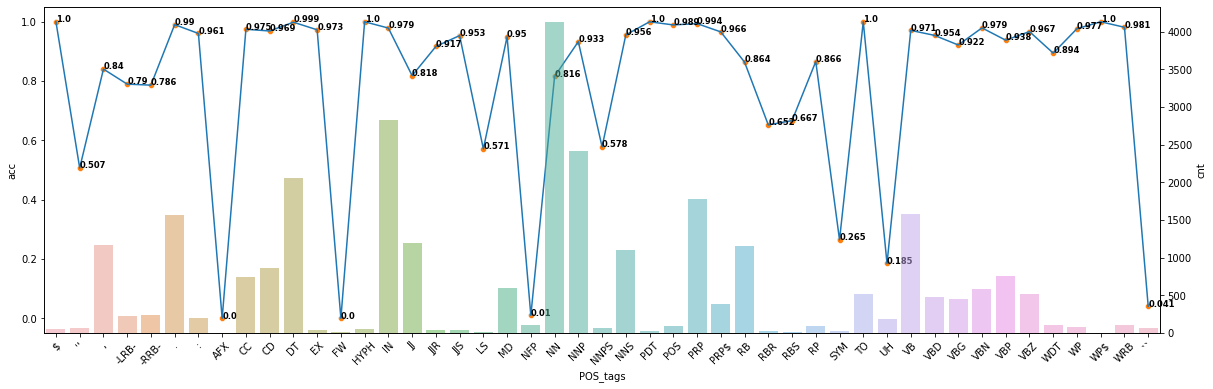

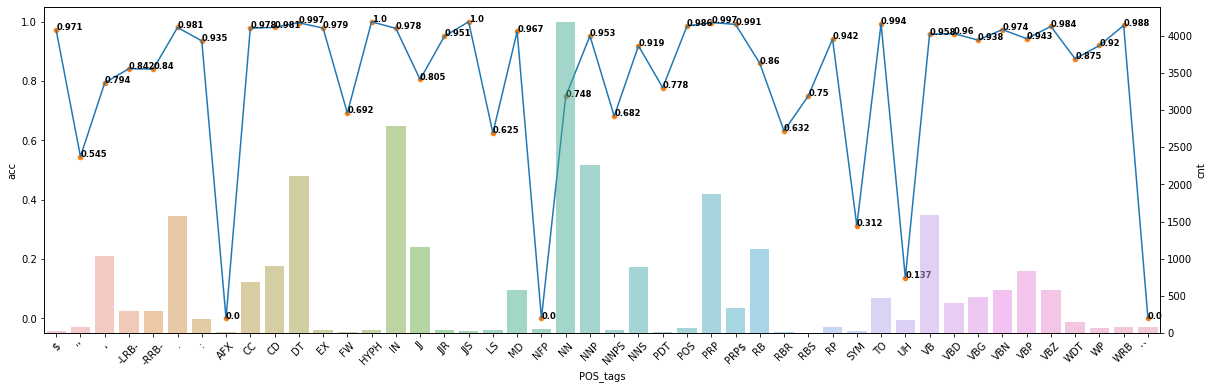

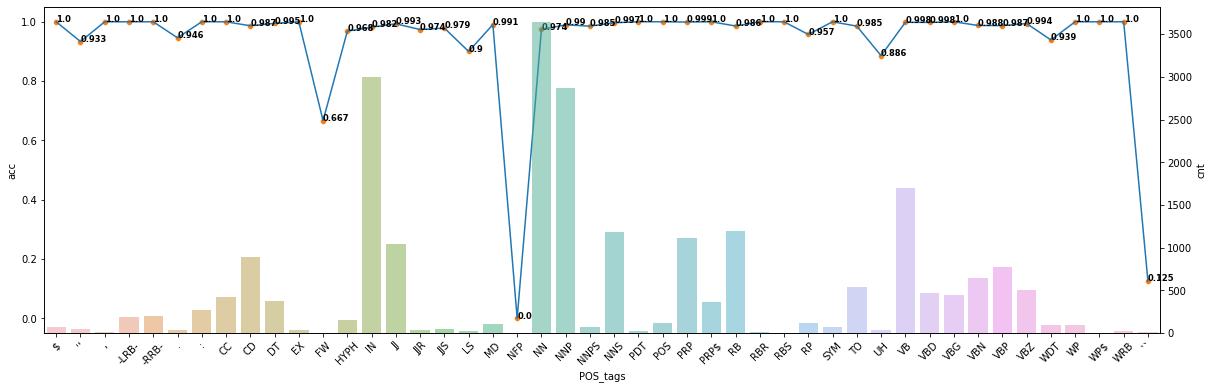

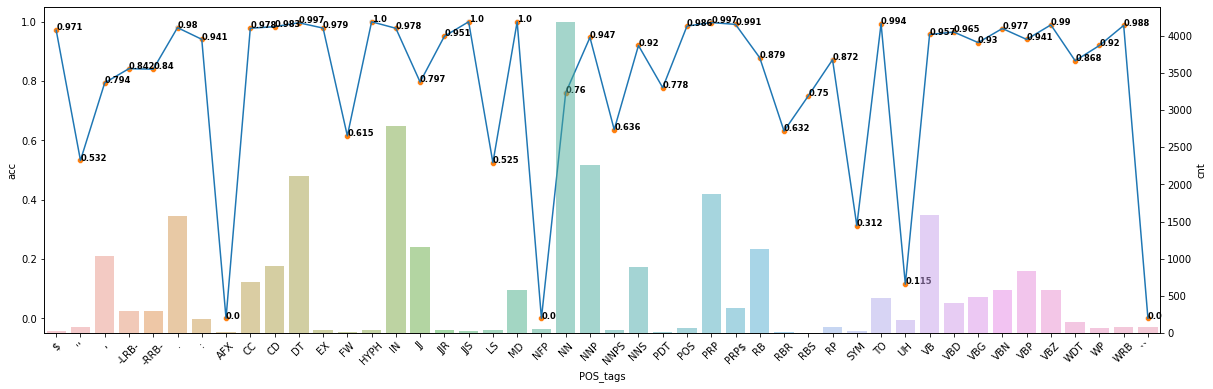

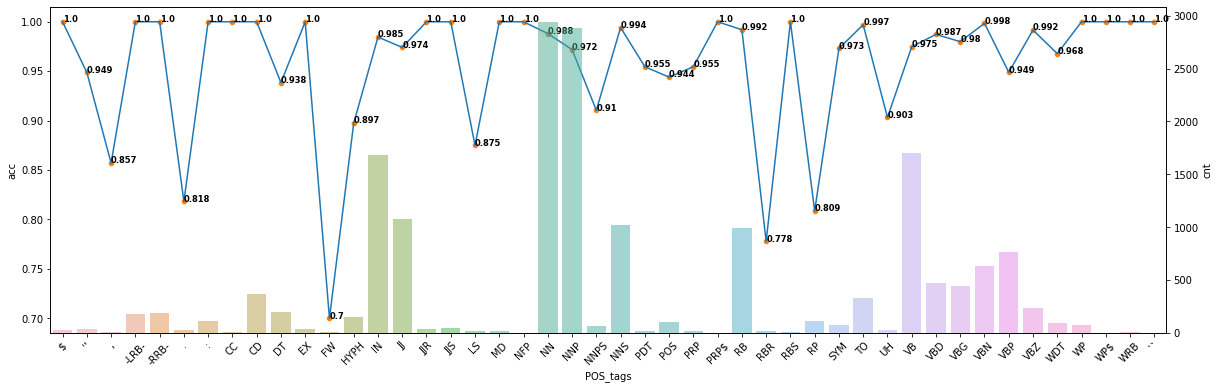

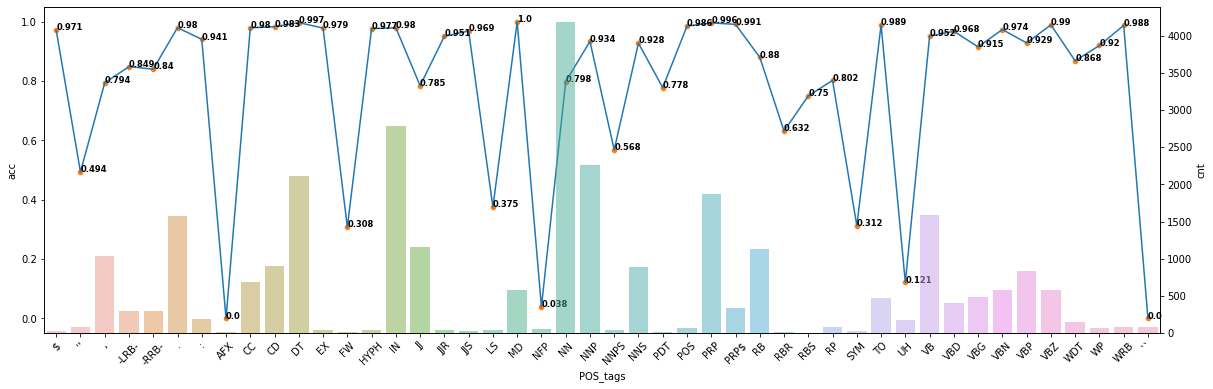

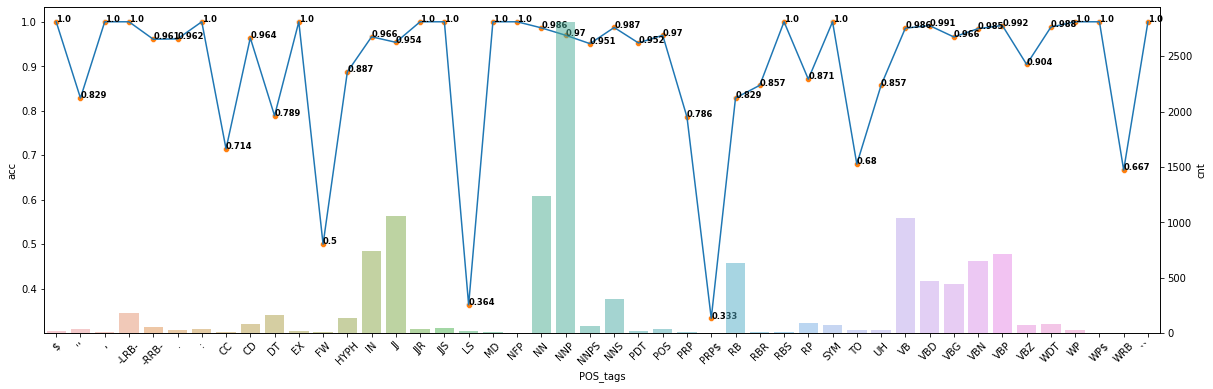

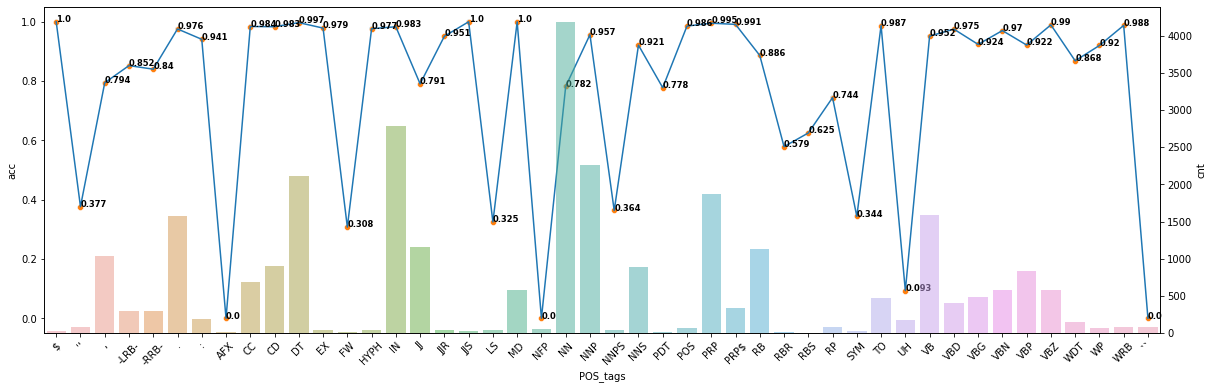

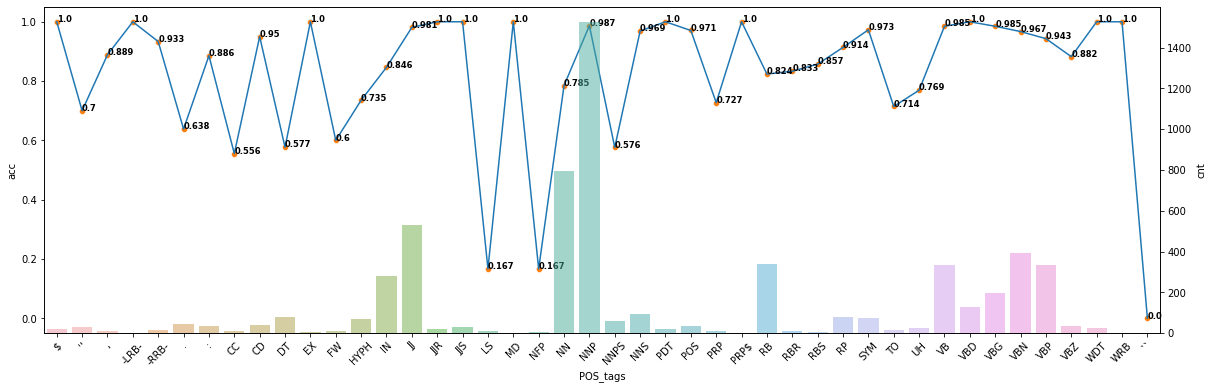

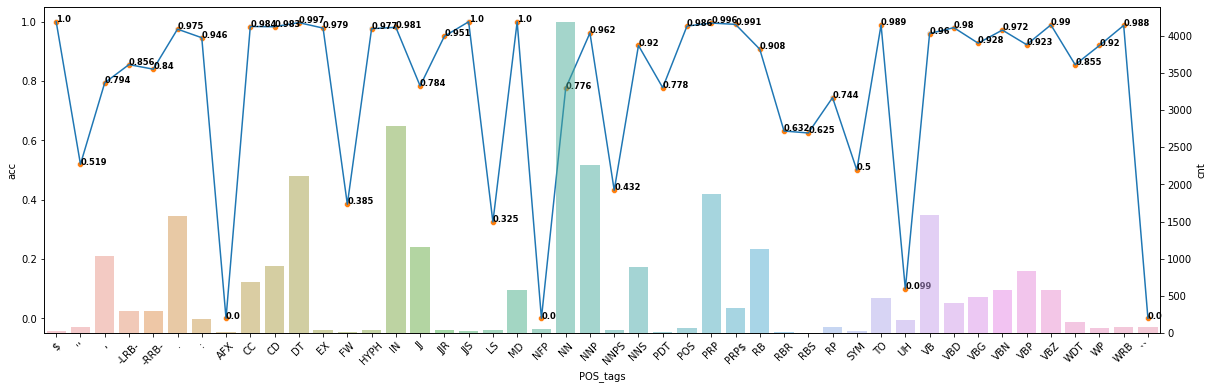

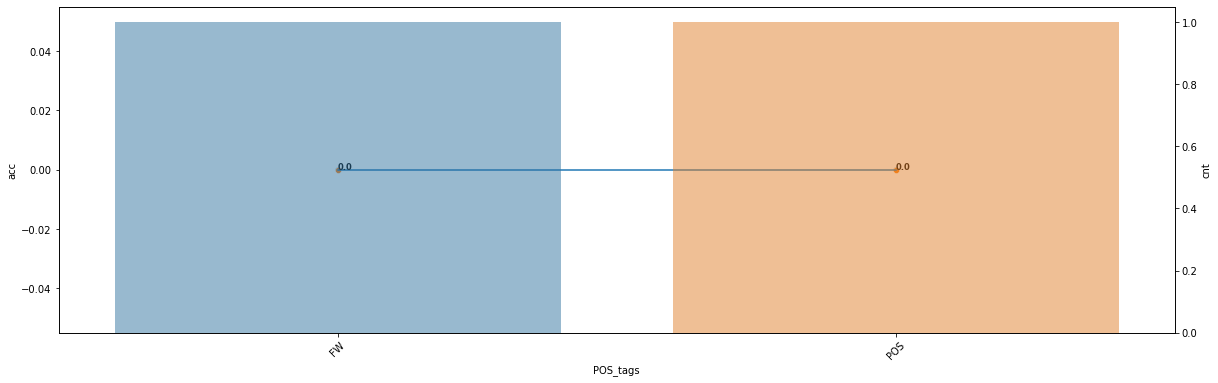

In [13]:
token_prob_lst = []

while cnt_non_ignored_tokens >= token_topn:
  loop_i += 1
  print("\nLoop", loop_i)
  print("domain_dev_word_lst", len(domain_dev_word_lst))

  domain_dev_dataset = PosDataset(domain_dev_word_lst, domain_dev_tag_lst)

  domain_dev_iter = data.DataLoader(dataset=domain_dev_dataset,
                              batch_size=8,
                              shuffle=False,
                              num_workers=1,
                              collate_fn=pad)

  # Save analysis outputs for intermediate results
  int_csv_file_name = os.path.join(sub_int_res_dir, f"top{token_top_percent}-loop{loop_i}.csv")
  int_output_plot_name = os.path.join(sub_int_res_dir, f"top{token_top_percent}-loop{loop_i}.png")
  output_int_res_file = os.path.join(sub_int_res_dir, f"top{token_top_percent}-loop{loop_i}.txt")

  (top_words, top_tags, top_pseudo_tags, top_prob_pseudo_tags, top_prob, top_acc,
   remain_words, remain_tags, remain_pseudo_tags, remain_prob_pseudo_tags, remain_prob, remain_acc) = gen_pseudo_data_for_token(
       model, domain_dev_iter, topn=len(domain_dev_word_lst), save_output=True, output_file=output_int_res_file, 
       csvsave=True, pngsave=True, csv_file_name=int_csv_file_name, output_plot_name=int_output_plot_name)

  print(len(top_prob_pseudo_tags))
  assert len(top_words)==len(top_tags)==len(top_prob_pseudo_tags)

  cnt_all_words = sum([len(s) for s in top_words])
  cnt_all_tags = sum([len(s) for s in top_tags])
  cnt_all_probs = sum([len(s) for s in top_prob_pseudo_tags])
  # print("Total tokens", cnt_all_probs)
  assert cnt_all_words==cnt_all_tags==cnt_all_probs

  non_ignored_tokens = []
  for tokens_i in top_tags:
    for token_i in tokens_i:
      if token_i != '<pad>':
        non_ignored_tokens.append(token_i)
  cnt_non_ignored_tokens = len(non_ignored_tokens)
  print("Total non_ignored tokens", cnt_non_ignored_tokens)
  if cnt_non_ignored_tokens <= 100:
    print("The number of non-ignored tokens is too few. Stop training")
    break

  # Calculate threshold_prob
  all_pseudo_tags_prob_lst = []
  for top_tags_i, top_prob_pseudo_tags_i in zip(top_tags, top_prob_pseudo_tags):
    for tags_i, prob_pseudo_tags_i in zip(top_tags_i, top_prob_pseudo_tags_i):
      if tags_i != '<pad>':
        all_pseudo_tags_prob_lst.append(prob_pseudo_tags_i)
  all_pseudo_tags_prob_lst.sort(reverse=True)

  if token_topn >= len(all_pseudo_tags_prob_lst):
    threshold_prob = all_pseudo_tags_prob_lst[-1]
    token_prob_lst.append(all_pseudo_tags_prob_lst)
  else:
    threshold_prob = all_pseudo_tags_prob_lst[token_topn]
    token_prob_lst.append(
        all_pseudo_tags_prob_lst[: token_topn+1]
        )
  print("threshold_prob:", threshold_prob)

  # Filter tags by prob
  filter_top_tags = []
  remain_top_tags = []
  for t, p in zip(top_pseudo_tags, top_prob_pseudo_tags):
    t_lst = []
    remain_t_lst = []
    for t_i, p_i in zip(t, p):
      if t_i == '<pad>':
        t_lst.append('<pad>')
        remain_t_lst.append('<pad>')
      else:
        if p_i >= threshold_prob:
          t_lst.append(t_i)
          remain_t_lst.append('<pad>')
        else:
          t_lst.append('<pad>')
          remain_t_lst.append(t_i)

    filter_top_tags.append(t_lst)
    remain_top_tags.append(remain_t_lst)

  assert len(top_words)==len(filter_top_tags)

  domain_dev_word_lst = top_words
  domain_dev_tag_lst = remain_top_tags

  new_train_dataset = PosDataset(top_words, filter_top_tags)
  new_train_iter = data.DataLoader(dataset=new_train_dataset,
                              batch_size=8,
                              shuffle=True,
                              num_workers=1,
                              collate_fn=pad)

  print("Online Training ...")
  # Set learning rate smaller to keep generalization ability
  optimizer = optim.Adam(model.parameters(), lr = 0.00001)
  criterion = nn.CrossEntropyLoss(ignore_index=0)

  train(model, new_train_iter, optimizer, criterion)
  
  # # Save models
  # model_file = os.path.join(sub_model_dir, f"top{top_percent}-loop{loop_i}.pt")
  # torch.save(model.state_dict(), model_file)

  # Save final results
  output_res_file = os.path.join(sub_result_dir, f"top{token_top_percent}-loop{loop_i}.txt")
  (domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value,
   precision_value_micro, recall_value_micro, f1_value_micro, acc_micro, 
   precision_value_macro, recall_value_macro, f1_value_macro, acc_macro) = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

  domain_precision_value_lst.append(domain_precision_value)
  domain_recall_value_lst.append(domain_recall_value)
  domain_f1_value_lst.append(domain_f1_value)
  domain_acc_value_lst.append(domain_acc_value)

  micro_domain_precision_value_lst.append(precision_value_micro)
  micro_domain_recall_value_lst.append(recall_value_micro)
  micro_domain_f1_value_lst.append(f1_value_micro)
  micro_domain_acc_value_lst.append(acc_micro)

  macro_domain_precision_value_lst.append(precision_value_macro)
  macro_domain_recall_value_lst.append(recall_value_macro)
  macro_domain_f1_value_lst.append(f1_value_macro)
  macro_domain_acc_value_lst.append(acc_macro)

  # Save analysis outputs for final results
  csv_file_name = os.path.join(sub_plots_tags_dir, f"top{token_top_percent}-loop{loop_i}.csv")
  output_plot_name = os.path.join(sub_plots_tags_dir, f"top{token_top_percent}-loop{loop_i}.png")
  _ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)



In [14]:
def plot_metric(precision, recall, f1, acc):

  test_metric = pd.DataFrame({
      "Loop": list(range(len(precision))) * 4,
      "metric": ["precision"]*len(precision) + ["recall"]*len(recall) + ["f1"]*len(f1) + ["accuracy"]*len(acc),
      "value": precision + recall + f1 + acc
  })

  fig = px.line(test_metric, x="Loop", y="value", color='metric', markers=True)
  fig.show()
  return test_metric

In [15]:
_ = plot_metric(domain_precision_value_lst, domain_recall_value_lst, domain_f1_value_lst, domain_acc_value_lst)

In [16]:
_ = plot_metric(micro_domain_precision_value_lst, micro_domain_recall_value_lst, micro_domain_f1_value_lst, micro_domain_acc_value_lst)

In [17]:
_ = plot_metric(macro_domain_precision_value_lst, macro_domain_recall_value_lst, macro_domain_f1_value_lst, macro_domain_acc_value_lst)

In [17]:
model, domain_precision_value_lst, domain_recall_value_lst, domain_f1_value_lst, domain_acc_value_lst, acc_lst, prob_lst = self_train(domain, topn_percent, threshold_ratio, lr, loop_upper_bound)

# metrics
test_metric = pd.DataFrame({
    "Loop": list(range(len(domain_precision_value_lst))),
    "precision": domain_precision_value_lst,
    "f1": domain_f1_value_lst,
    "acc": domain_acc_value_lst,
    "recall": domain_recall_value_lst
    })
print(test_metric)
acc_prob = pd.DataFrame({
    "acc_lst": acc_lst,
    "prob_lst": prob_lst,
    })

In [17]:
# metrics
test_metric = pd.DataFrame({
    "Loop": list(range(len(domain_precision_value_lst))),
    "precision": domain_precision_value_lst,
    "f1": domain_f1_value_lst,
    "acc": domain_acc_value_lst,
    "recall": domain_recall_value_lst
    })